In [1]:
# to import a local copy of dem
import os
import sys
sys.path.insert(0, os.path.abspath('../../dem'))

from cvxpower import *

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#from config import *

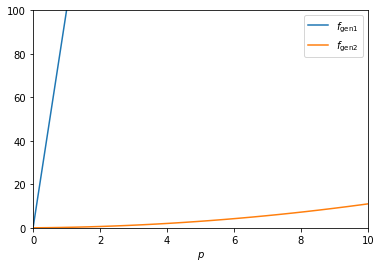

In [2]:
alpha1, beta1, pmax1 = 0.01, 100, 1000
alpha2, beta2, pmax2 = 0.1, 0.1, 100

#plt.figure(figsize=FIGREGULAR)
xs = np.linspace(0,20)
plt.plot(xs, alpha1*xs**2 + beta1*xs, label=r'$f_{\rm gen1}$')
plt.plot(xs, alpha2*xs**2 + beta2*xs, label=r'$f_{\rm gen2}$')
plt.legend()
plt.xlabel(r'$p$')
plt.xlim([0, 10])
plt.ylim([0, min(pmax1, pmax2)])
plt.savefig("three_bus_gen_cost.pdf")

In [3]:
load1 = FixedLoad(power=50, name="load1")
load2 = FixedLoad(power=100, name="load2")

gen1 = Generator(power_max=1000,
  alpha=0.01, beta=100, name="gen1")
gen2 = Generator(power_max=100, alpha=0.1,
  beta=0.1, name="gen2")

line1 = TransmissionLine(power_max=50, name = 'line1', alpha=0.001)
#line1 = TransmissionLine(name = 'line1', alpha=0.001)
line2 = TransmissionLine(power_max=10, name = 'line2')
line3 = TransmissionLine(power_max=50, name = 'line3')

net1 = Net([load1.terminals[0],
    gen1.terminals[0], line1.terminals[0],
    line2.terminals[0]], name = 'net1')
net2 = Net([load2.terminals[0], line1.terminals[1], 
    line3.terminals[0]], name = 'net2')
net3 = Net([gen2.terminals[0], line2.terminals[1], 
    line3.terminals[1]], name = 'net3')
network = Group([load1, load2, gen1, gen2,
    line1, line2, line3],
    [net1, net2, net3])

network.init_problem()
network.optimize()
print(network.results.summary())

{<cvxpower.devices.TransmissionLine object at 0xa6c5830c>: 0, <cvxpower.devices.TransmissionLine object at 0xa6c5802c>: 0, <cvxpower.devices.FixedLoad object at 0xa6c0304c>: 0, <cvxpower.devices.Generator object at 0xa6c58a6c>: 0, <cvxpower.devices.Generator object at 0xa6c585ac>: 0, <cvxpower.devices.FixedLoad object at 0xa6c03a2c>: 0, <cvxpower.devices.TransmissionLine object at 0xa6c58eec>: 0}
Status: optimal
Terminal                  Power
--------                  -----
load1[0]                  50.00
gen2[0]                  -60.00
gen1[0]                  -92.63
line3[1]                  50.00
line2[1]                  10.00
line3[0]                 -50.00
line1[1]                 -50.00
line2[0]                 -10.00
line1[0]                  52.63
load2[0]                 100.00

Net                       Price
---                       -----
net3                    12.0988
net1                   101.8528
net2                   112.8717

Device                  Payment
------